In [277]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

In [237]:
#Import data
shrine_players = pd.read_parquet('data/shrine_bowl_players.parquet', engine='fastparquet')
shrine_players.rename(columns={'gsis_player_id': 'college_gsis_id'}, inplace=True)
shrine_players['college_gsis_id'] = shrine_players['college_gsis_id'].astype(int)
# Save as CSV for easier viewing
shrine_players.to_csv('data/shrine_bowl_players.csv', index=False)

college_stats = pd.read_csv('data/shrine_bowl_players_college_stats.csv')
nfl_stats = pd.read_csv('data/shrine_bowl_players_nfl_rookie_stats.csv')
sos_stats = pd.read_csv('data/sos_data.csv')
team_offense = pd.read_csv('data/CFB_TeamOff_2017-2024_via_sportsReference.csv')
combine_data = pd.read_csv('data/combine_data.csv')

print(shrine_players.shape, college_stats.shape, nfl_stats.shape, sos_stats.shape)

(338, 33) (1732, 38) (245, 43) (1181, 7)


In [238]:
shrine_players.head()

,college_gsis_id,first_name,last_name,football_name,weight,hand_size,last_twenty_of_forty_yd_dash,first_ten_of_forty_yd_dash,standing_broad_jump,three_cone,...,draft_round,draft_pick,draft_overall_selection,hometown,hometown_state,hometown_country,recruiting_stars,team_code,team_name,conference
0,350698,Dwight,McGlothern,Dwight,189.0,8.5,1.8699999,1.55,111.0,7.23,...,None,None,None,Houston,TX,US,4,ARUN,Arkansas Razorbacks,Southeastern Conference
1,336849,Hunter,Nourzad,Hunter,319.0,10.75,None,None,None,None,...,5,24,160,Marietta,GA,US,None,PAST,Penn State Nittany Lions,Big Ten Conference
2,362959,Jaden,Shirden,Jaden,189.0,9.25,1.8799999,1.56,117.0,None,...,None,None,None,West Haven,CT,US,None,NJMO,Monmouth Hawks,Colonial Athletic Association
3,324852,David,Ugwoegbu,David,243.0,10.25,1.97,1.75,116.0,7.56,...,None,None,None,Katy,TX,US,3,TXHO,Houston Cougars,Big Twelve Conference
4,304792,Ernest,Perry,E.J.,208.0,9.0,1.99,1.58,123.0,6.85,...,None,None,None,Andover,MA,US,3,RIBR,Brown Bears,Ivy League


In [239]:
college_stats.head()

,college_gsis_id,position,player_name,season,team,school_code,passing_attempts,passing_completions,passing_yards,passing_completion_percentage,...,kickreturns_no,kickreturns_touchdowns,kickreturns_yards,puntreturns_avg,puntreturns_long,puntreturns_no,puntreturns_td,puntreturns_yds,total_fumbles,total_fumbles_lost
0,158332,DT,Garrett Marino,2017,UAB,ALBI,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,158332,DT,Garrett Marino,2018,UAB,ALBI,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,158332,DT,Garrett Marino,2019,UAB,ALBI,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,172387,DS,Austin Lee,2017,BYU,UTBY,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,172387,DS,Austin Lee,2018,BYU,UTBY,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [240]:
nfl_stats.head()

,college_gsis_id,rookie_season,player_name,position,draft_season,draft_round,draft_overall_selection,scrambles,qb_pressures,qb_pressure_to_sack_rate,...,rushing_yards,rushing_touchdowns,receiving_targets,receiving_receptions,receiving_yards,receiving_yards_per_route_run,receiving_touchdowns,receiving_yards_after_catch,defense_interceptions,defense_pass_breakups
0,196601,2020,Khalil Davis,DT,2020,6.0,194.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,305707,2024,Dallas Gant,IB,2024,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,316846,2023,Moro Ojomo,DT,2023,7.0,249.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,196251,2020,Alex Highsmith,DE,2020,3.0,102.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
4,282907,2022,Samori Toure,WR,2022,7.0,258.0,NaN,NaN,NaN,...,NaN,NaN,10.0,5.0,82.0,1.108108,1.0,11.0,NaN,NaN


In [241]:
sos_stats.head()

,Rank,Team,Rating,Hi,Lo,Last,Year
0,1,Indiana,17.3,1,68,2,2025
1,2,Ohio St,16.0,2,18,14,2025
2,3,Alabama,15.5,1,21,1,2025
3,4,Oregon,15.4,1,71,3,2025
4,5,Texas,13.8,1,20,8,2025


In [242]:
# Get standerdized SOS values
sos_mean = sos_stats['Rating'].mean()
sos_std = sos_stats['Rating'].std()
sos_stats['Rating'] = (sos_stats['Rating'] - sos_mean) / sos_std
sos_stats.head()

,Rank,Team,Rating,Hi,Lo,Last,Year
0,1,Indiana,2.244937,1,68,2,2025
1,2,Ohio St,2.083466,2,18,14,2025
2,3,Alabama,2.021361,1,21,1,2025
3,4,Oregon,2.008941,1,71,3,2025
4,5,Texas,1.810207,1,20,8,2025


In [243]:
print(college_stats.columns)
print(college_stats['position'].unique())
print((college_stats['player_name'].nunique()))

Index(['college_gsis_id', 'position', 'player_name', 'season', 'team',
       'school_code', 'passing_attempts', 'passing_completions',
       'passing_yards', 'passing_completion_percentage', 'passing_touchdowns',
       'passing_interceptions', 'rushing_attempts', 'rushing_yards',
       'rushing_touchdowns', 'receiving_receptions', 'receiving_touchdowns',
       'receiving_yards', 'defense_pass_breakups', 'defense_qb_hurries',
       'defense_sacks', 'defense_solo_tackles', 'defense_total_tackles',
       'defense_tackles_for_loss', 'defense_interceptions',
       'defense_touchdowns', 'kickreturns_avg', 'kickreturns_long',
       'kickreturns_no', 'kickreturns_touchdowns', 'kickreturns_yards',
       'puntreturns_avg', 'puntreturns_long', 'puntreturns_no',
       'puntreturns_td', 'puntreturns_yds', 'total_fumbles',
       'total_fumbles_lost'],
      dtype='object')
['DT' 'DS' 'WR' 'DC' 'QB' 'DE' 'RB' 'OB' 'IB' 'OG' 'TE' 'OT' 'OC' 'FB']
465


In [244]:
#Get stat shares
college_stats['rec_yds_share'] = np.nan
college_stats['rec_td_share'] = np.nan
college_stats['rec_cmp_share'] = np.nan
college_stats['rush_yds_share'] = np.nan
college_stats['rush_td_share'] = np.nan
college_stats['rush_atmp_share'] = np.nan
college_stats['pass_yds_share'] = np.nan
college_stats['pass_td_share'] = np.nan
college_stats['opp_sos_rating'] = np.nan

for index, row in college_stats.iterrows():
    team = row['team']
    year = row['season']
    team_totals = team_offense[((team_offense['School'] == team) & (team_offense['Year'] == year))][['tot_pass_yds','tot_pass_td','tot_pass_cmp','tot_rush_yds','tot_rush_td','tot_rush_atmp', 'Total_Yds', 'Pts', 'G']]
    team_sos = sos_stats[(sos_stats['Team'] == team) & (sos_stats['Year'] == year)]['Rating']

    if not team_totals.empty:
        team_totals = team_totals.iloc[0]
        college_stats.loc[index, 'rec_yds_share'] = row['receiving_yards'] / team_totals['tot_pass_yds']
        college_stats.loc[index, 'rec_td_share'] = row['receiving_touchdowns'] / team_totals['tot_pass_td']
        college_stats.loc[index, 'rec_cmp_share'] = row['receiving_receptions'] / team_totals['tot_pass_cmp']
        college_stats.loc[index, 'rush_yds_share'] = row['rushing_yards'] / team_totals['tot_rush_yds']
        college_stats.loc[index, 'rush_td_share'] = row['rushing_touchdowns'] / team_totals['tot_rush_td']
        college_stats.loc[index, 'rush_atmp_share'] = row['rushing_attempts'] / team_totals['tot_rush_atmp']
        college_stats.loc[index, 'pass_yds_share'] = row['passing_yards'] / (team_totals['Total_Yds'] * team_totals['G'])
        college_stats.loc[index, 'pass_td_share'] = row['passing_touchdowns'] / (team_totals['tot_pass_td'] + team_totals['tot_rush_td'])
        college_stats.loc[index, 'opp_sos_rating'] = team_sos.values[0] if not team_sos.empty else np.nan

In [245]:

college_stats.head(20)

,college_gsis_id,position,player_name,season,team,school_code,passing_attempts,passing_completions,passing_yards,passing_completion_percentage,...,total_fumbles_lost,rec_yds_share,rec_td_share,rec_cmp_share,rush_yds_share,rush_td_share,rush_atmp_share,pass_yds_share,pass_td_share,opp_sos_rating
0,158332,DT,Garrett Marino,2017,UAB,ALBI,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.717319
1,158332,DT,Garrett Marino,2018,UAB,ALBI,NaN,NaN,NaN,NaN,...,0.0,-0.003145,0.000000,0.005263,0.001773,0.000000,0.004839,NaN,NaN,-0.872700
2,158332,DT,Garrett Marino,2019,UAB,ALBI,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.344693
3,172387,DS,Austin Lee,2017,BYU,UTBY,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,172387,DS,Austin Lee,2018,BYU,UTBY,1.0,0.0,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,172387,DS,Austin Lee,2019,BYU,UTBY,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,172698,WR,Nick Westbrook,2018,Indiana,INUN,NaN,NaN,NaN,NaN,...,NaN,0.190692,0.200000,0.132911,NaN,NaN,NaN,NaN,NaN,0.617804
7,172698,WR,Nick Westbrook,2019,Indiana,INUN,NaN,NaN,NaN,NaN,...,NaN,0.145510,0.217391,0.130841,NaN,NaN,NaN,NaN,NaN,0.704750
8,172890,DC,Chris Williamson,2018,Minnesota,MNUN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.592962
9,172890,DC,Chris Williamson,2019,Minnesota,MNUN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.878642


In [246]:
college_totals = (
    college_stats
    .groupby("college_gsis_id", as_index=False)
    .agg(
        team=('team', 'last'),
        max_season=('season', 'max'),
        position=('position', 'first'),
        receiving_receptions=('receiving_receptions', 'sum'),
        receiving_yards=('receiving_yards', 'sum'),
        receiving_touchdowns=('receiving_touchdowns', 'sum'),
        rushing_attempts=('rushing_attempts', 'sum'),
        rushing_yards=('rushing_yards', 'sum'),
        rushing_touchdowns=('rushing_touchdowns', 'sum'),
        passing_completions=('passing_completions', 'sum'),
        passing_yards=('passing_yards', 'sum'),
        passing_touchdowns=('passing_touchdowns', 'sum'),
        passing_interceptions=('passing_interceptions', 'sum'),
        seasons_played=('position', 'size'),
        avg_rec_yds_share=('rec_yds_share', 'mean'),
        avg_rec_td_share=('rec_td_share', 'mean'),
        avg_rec_cmp_share=('rec_cmp_share', 'mean'),
        avg_rush_yds_share=('rush_yds_share', 'mean'),
        avg_rush_td_share=('rush_td_share', 'mean'),
        avg_rush_atmp_share=('rush_atmp_share', 'mean'),
        max_rec_yds_share=('rec_yds_share', 'max'),
        max_rec_td_share=('rec_td_share', 'max'),
        max_rec_cmp_share=('rec_cmp_share', 'max'),
        max_rush_yds_share=('rush_yds_share', 'max'),
        max_rush_td_share=('rush_td_share', 'max'),
        max_rush_atmp_share=('rush_atmp_share', 'max'),
        avg_pass_yds_share=('pass_yds_share', 'mean'),
        avg_pass_td_share=('pass_td_share', 'mean'),
        max_pass_yds_share=('pass_yds_share', 'max'),
        max_pass_td_share=('pass_td_share', 'max'),
        avg_opp_sos_rating=('opp_sos_rating', 'mean')
    )
)
print(college_totals.shape)
college_totals.head()

(465, 32)


,college_gsis_id,team,max_season,position,receiving_receptions,receiving_yards,receiving_touchdowns,rushing_attempts,rushing_yards,rushing_touchdowns,...,max_rec_td_share,max_rec_cmp_share,max_rush_yds_share,max_rush_td_share,max_rush_atmp_share,avg_pass_yds_share,avg_pass_td_share,max_pass_yds_share,max_pass_td_share,avg_opp_sos_rating
0,158332,UAB,2019,DT,1.0,-9.0,0.0,3.0,5.0,0.0,...,0.000000,0.005263,0.001773,0.000000,0.004839,NaN,NaN,NaN,NaN,-1.311570
1,172387,BYU,2019,DS,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,172698,Indiana,2019,WR,84.0,1162.0,9.0,0.0,0.0,0.0,...,0.217391,0.132911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.661277
3,172890,Minnesota,2019,DC,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.735802
4,173519,Missouri,2019,QB,0.0,0.0,0.0,328.0,1037.0,14.0,...,NaN,NaN,0.243590,0.268293,0.332756,0.338753,0.243579,0.493143,0.483871,1.226426


In [247]:
college_totals[college_totals['college_gsis_id'] == 332504].head()

,college_gsis_id,team,max_season,position,receiving_receptions,receiving_yards,receiving_touchdowns,rushing_attempts,rushing_yards,rushing_touchdowns,...,max_rec_td_share,max_rec_cmp_share,max_rush_yds_share,max_rush_td_share,max_rush_atmp_share,avg_pass_yds_share,avg_pass_td_share,max_pass_yds_share,max_pass_td_share,avg_opp_sos_rating
290,332504,Western Kentucky,2023,QB,0.0,0.0,0.0,132.0,332.0,12.0,...,NaN,NaN,0.114229,0.533333,0.217391,0.659096,0.654828,0.681825,0.689655,NaN


In [248]:
college_nfl_merged = pd.merge(college_totals, nfl_stats, on='college_gsis_id', how='left', suffixes=('_college', '_nfl'))
college_nfl_merged.head()

,college_gsis_id,team,max_season,position_college,receiving_receptions_college,receiving_yards_college,receiving_touchdowns_college,rushing_attempts_college,rushing_yards_college,rushing_touchdowns_college,...,rushing_yards_nfl,rushing_touchdowns_nfl,receiving_targets,receiving_receptions_nfl,receiving_yards_nfl,receiving_yards_per_route_run,receiving_touchdowns_nfl,receiving_yards_after_catch,defense_interceptions,defense_pass_breakups
0,158332,UAB,2019,DT,1.0,-9.0,0.0,3.0,5.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,172387,BYU,2019,DS,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,172698,Indiana,2019,WR,84.0,1162.0,9.0,0.0,0.0,0.0,...,NaN,NaN,8.0,3.0,33.0,NaN,NaN,5.0,NaN,NaN
3,172890,Minnesota,2019,DC,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,173519,Missouri,2019,QB,0.0,0.0,0.0,328.0,1037.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [249]:
# A player is considered to have played in the NFL if they have played more than 30 snaps
college_nfl_merged['played_in_nfl'] = college_nfl_merged['total_snaps'].apply(lambda x: 1 if x > 30 else 0)

wr_merged = college_nfl_merged[college_nfl_merged['position_college'] == 'WR']
qb_merged = college_nfl_merged[college_nfl_merged['position_college'] == 'QB']
te_merged = college_nfl_merged[college_nfl_merged['position_college'] == 'TE']
rb_merged = college_nfl_merged[college_nfl_merged['position_college'] == 'RB']

## WR

In [250]:
wr_merged.head()

,college_gsis_id,team,max_season,position_college,receiving_receptions_college,receiving_yards_college,receiving_touchdowns_college,rushing_attempts_college,rushing_yards_college,rushing_touchdowns_college,...,rushing_touchdowns_nfl,receiving_targets,receiving_receptions_nfl,receiving_yards_nfl,receiving_yards_per_route_run,receiving_touchdowns_nfl,receiving_yards_after_catch,defense_interceptions,defense_pass_breakups,played_in_nfl
2,172698,Indiana,2019,WR,84.0,1162.0,9.0,0.0,0.0,0.0,...,NaN,8.0,3.0,33.0,NaN,NaN,5.0,NaN,NaN,1
14,191527,Louisiana,2019,WR,139.0,1989.0,22.0,3.0,30.0,0.0,...,NaN,11.0,5.0,60.0,NaN,NaN,9.0,NaN,NaN,1
22,194682,Missouri,2019,WR,129.0,1755.0,11.0,3.0,21.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
36,195293,Florida,2019,WR,73.0,961.0,6.0,8.0,133.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
37,195298,Florida,2019,WR,61.0,884.0,13.0,4.0,27.0,0.0,...,NaN,21.0,13.0,159.0,NaN,2.0,102.0,NaN,NaN,1


### TODO NEXT
Find correlation between wr_metric and nfl performance/ playing time
- Model for both playing time and production separately
- Does this metric seperate opportunty from abillity?
- THIS SEPERATION is how we find undervalued players

### Modeling

In [251]:
offense_merged = college_nfl_merged[
    (college_nfl_merged['position_college'].isin(['WR', 'TE', 'RB', 'QB']))
]
print(college_nfl_merged.shape)
print(offense_merged.shape)

(465, 75)
(161, 75)


(array([16.,  3.,  1.,  3.,  0.,  4.,  2.,  0.,  1.,  0.,  1.,  5.,  0.,
         1.,  2.,  1.,  3.,  0.,  0.,  1.,  0.,  3.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  2. ,  32.3,  62.6,  92.9, 123.2, 153.5, 183.8, 214.1, 244.4,
        274.7, 305. , 335.3, 365.6, 395.9, 426.2, 456.5, 486.8, 517.1,
        547.4, 577.7, 608. , 638.3, 668.6, 698.9, 729.2, 759.5, 789.8,
        820.1, 850.4, 880.7, 911. ]),
 <BarContainer object of 30 artists>)

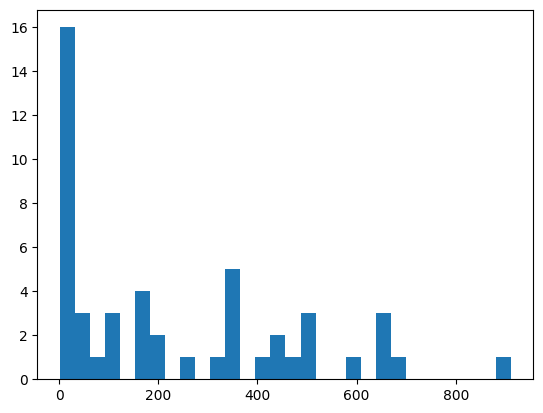

In [252]:

plt.hist(offense_merged['total_snaps'], bins=30)

## Athleticism Model (All positions)

In [253]:
college_nfl_merged = college_nfl_merged[college_nfl_merged['max_season'] > 2019]

In [254]:
full_merge = pd.merge(shrine_players, college_nfl_merged, on='college_gsis_id', how='inner')
print(full_merge.shape)
print(shrine_players.shape)
print(college_nfl_merged.shape)
full_merge.head(20)

(187, 107)
(338, 33)
(370, 75)


,college_gsis_id,first_name,last_name,football_name,weight,hand_size,last_twenty_of_forty_yd_dash,first_ten_of_forty_yd_dash,standing_broad_jump,three_cone,...,rushing_touchdowns_nfl,receiving_targets,receiving_receptions_nfl,receiving_yards_nfl,receiving_yards_per_route_run,receiving_touchdowns_nfl,receiving_yards_after_catch,defense_interceptions,defense_pass_breakups,played_in_nfl
0,350698,Dwight,McGlothern,Dwight,189.0,8.5,1.8699999,1.55,111.0,7.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
1,362959,Jaden,Shirden,Jaden,189.0,9.25,1.8799999,1.56,117.0,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,324852,David,Ugwoegbu,David,243.0,10.25,1.97,1.75,116.0,7.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,330326,Jared,Harrison-Hunte,Jared,290.0,9.5,None,1.69,111.0,7.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,351359,Robert,Longerbeam,Robert,174.0,8.5,None,1.5,134.0,6.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,373367,Trey,Taylor,Trey,206.0,9.25,1.96,1.59,123.0,6.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,348991,Elijah,Roberts,Elijah,292.0,10.5,None,1.67,116.0,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,325610,Deantre,Prince,Deantre,184.0,8.625,1.8000002,1.55,125.0,7.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
8,309574,David,White,David,201.0,9.5,1.8899999,1.59,123.0,7.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,349410,Lideatrick,Griffin,Lideatrick,182.0,9.375,1.8499999,1.54,124.0,7.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [255]:
full_merge['acceleration_factor'] = full_merge['first_twenty_of_forty_yd_dash'].astype(float) - full_merge['last_twenty_of_forty_yd_dash'].astype(float)

In [256]:
# Rank performance within position groups as a percentile (note that lower is better for time based metrics)
position_groups = full_merge['position_college'].unique()
for position in position_groups:
    position_mask = full_merge['position_college'] == position
    full_merge.loc[position_mask, 'three_cone_percentile'] = full_merge[position_mask]['three_cone'].rank(pct=True, ascending=False)
    full_merge.loc[position_mask, 'weight_percentile'] = full_merge[position_mask]['weight'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'hand_size_percentile'] = full_merge[position_mask]['hand_size'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'forty_percentile'] = full_merge[position_mask]['forty_yd_dash'].rank(pct=True, ascending=False)
    full_merge.loc[position_mask, 'standing_broad_jump_percentile'] = full_merge[position_mask]['standing_broad_jump'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'height_percentile'] = full_merge[position_mask]['height'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'wingspan_percentile'] = full_merge[position_mask]['wingspan'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'vert_percentile'] = full_merge[position_mask]['standing_vertical'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'bench_percentile'] = full_merge[position_mask]['bench_reps_of_225'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'twenty_percentile'] = full_merge[position_mask]['twenty_yard_shuttle'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'arm_length_percentile'] = full_merge[position_mask]['arm_length'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'acceleration_factor_percentile'] = full_merge[position_mask]['acceleration_factor'].rank(pct=True, ascending=True)

In [257]:
for index, row in full_merge.iterrows():
    if pd.isna(row['birthdate']) or pd.isna(row['draft_season_x']):
        full_merge.loc[index, 'age_at_draft'] = np.nan
    else:
        birthdate = pd.to_datetime(row['birthdate'])
        draft_year = int(row['draft_season_x'])
        draft_date = pd.to_datetime(f"{draft_year}-04-01")  # Approximate draft date as April 1st
        age_at_draft = (draft_date - birthdate).days / 365.25
        full_merge.loc[index, 'age_at_draft'] = age_at_draft

In [258]:
full_merge.head(10)

,college_gsis_id,first_name,last_name,football_name,weight,hand_size,last_twenty_of_forty_yd_dash,first_ten_of_forty_yd_dash,standing_broad_jump,three_cone,...,forty_percentile,standing_broad_jump_percentile,height_percentile,wingspan_percentile,vert_percentile,bench_percentile,twenty_percentile,arm_length_percentile,acceleration_factor_percentile,age_at_draft
0,350698,Dwight,McGlothern,Dwight,189.0,8.5,1.8699999,1.55,111.0,7.23,...,0.607143,0.074074,0.892857,0.196429,0.035714,NaN,0.629630,0.446429,0.560000,22.149213
1,362959,Jaden,Shirden,Jaden,189.0,9.25,1.8799999,1.56,117.0,None,...,0.807692,0.416667,0.115385,0.076923,0.416667,NaN,NaN,0.076923,0.454545,21.916496
2,324852,David,Ugwoegbu,David,243.0,10.25,1.97,1.75,116.0,7.56,...,0.230769,0.230769,0.600000,0.866667,0.115385,0.458333,1.000000,0.866667,0.777778,23.548255
3,330326,Jared,Harrison-Hunte,Jared,290.0,9.5,None,1.69,111.0,7.76,...,0.947368,0.638889,0.545455,0.454545,0.886364,NaN,0.275000,0.795455,NaN,24.692676
4,351359,Robert,Longerbeam,Robert,174.0,8.5,None,1.5,134.0,6.76,...,0.750000,1.000000,0.250000,0.678571,0.553571,NaN,0.296296,0.607143,NaN,24.199863
5,373367,Trey,Taylor,Trey,206.0,9.25,1.96,1.59,123.0,6.9,...,0.176471,0.500000,0.558824,0.470588,0.529412,0.966667,0.214286,0.647059,0.153846,23.167693
6,348991,Elijah,Roberts,Elijah,292.0,10.5,None,1.67,116.0,None,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,23.268994
7,325610,Deantre,Prince,Deantre,184.0,8.625,1.8000002,1.55,125.0,7.46,...,0.910714,0.722222,0.500000,0.285714,0.732143,0.352941,NaN,0.500000,0.800000,23.468857
8,309574,David,White,David,201.0,9.5,1.8899999,1.59,123.0,7.05,...,0.326923,0.519231,0.750000,0.461538,0.615385,0.357143,0.090909,0.634615,0.842105,23.704312
9,349410,Lideatrick,Griffin,Lideatrick,182.0,9.375,1.8499999,1.54,124.0,7.04,...,0.865385,0.653846,0.384615,0.307692,0.538462,NaN,0.613636,0.384615,0.473684,23.186858


In [259]:
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
features = [
    'three_cone_percentile',
    'weight_percentile',
    'hand_size_percentile',
    'forty_percentile',
    'standing_broad_jump_percentile',
    'height_percentile',
    'wingspan_percentile',
    'vert_percentile',
    'bench_percentile',
    'twenty_percentile',
    'arm_length_percentile',
    'acceleration_factor_percentile',
    'age_at_draft',
]

X = full_merge[features]
y = full_merge['played_in_nfl']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(y_test.value_counts())

model.fit(X_train, y_train)

played_in_nfl
0    30
1     8
Name: count, dtype: int64


C:\Users\bps78\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:04:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [260]:
print(model.score(X_test, y_test))
importances = model.feature_importances_
pd.DataFrame({'Feature': model.feature_names_in_, 'Importance': importances}).sort_values(by='Importance', ascending=False)

0.6842105263157895


,Feature,Importance
7,vert_percentile,0.129632
5,height_percentile,0.098436
2,hand_size_percentile,0.092991
9,twenty_percentile,0.088710
11,acceleration_factor_percentile,0.083970
10,arm_length_percentile,0.079010
6,wingspan_percentile,0.076048
1,weight_percentile,0.065231
4,standing_broad_jump_percentile,0.061566
8,bench_percentile,0.061002


In [261]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred_proba = model.predict_proba(X_test)[:, 1]
top_k = int(0.2 * len(y_test))
top_preds = y_test.iloc[np.argsort(-y_pred_proba)[:top_k]]

print("Top 20% hit rate:", top_preds.mean())
print("Baseline hit rate:", y_test.mean())
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

Top 20% hit rate: 0.2857142857142857
Baseline hit rate: 0.21052631578947367
ROC AUC: 0.65


## Offensive Efficiency Model (Skill Positions)

In [262]:
# Rank offensive efficiency within position groups as a percentile
off_position_groups = ['WR', 'TE', 'RB', 'QB']
for position in off_position_groups:
    if(position == 'WR' or position == 'TE'):
       position_mask = full_merge['position_college'] == position
       full_merge.loc[position_mask, 'avg_yds_share_percentile'] = full_merge[position_mask]['avg_rec_yds_share'].rank(pct=True, ascending=True)
       full_merge.loc[position_mask, 'max_yds_share_percentile'] = full_merge[position_mask]['max_rec_yds_share'].rank(pct=True, ascending=True)
       full_merge.loc[position_mask, 'avg_td_share_percentile'] = full_merge[position_mask]['avg_rec_td_share'].rank(pct=True, ascending=True)
       full_merge.loc[position_mask, 'max_td_share_percentile'] = full_merge[position_mask]['max_rec_td_share'].rank(pct=True, ascending=True)

    elif(position == 'RB'):
         position_mask = full_merge['position_college'] == position
         full_merge.loc[position_mask, 'avg_yds_share_percentile'] = full_merge[position_mask]['avg_rush_yds_share'].rank(pct=True, ascending=True)
         full_merge.loc[position_mask, 'max_yds_share_percentile'] = full_merge[position_mask]['max_rush_yds_share'].rank(pct=True, ascending=True)
         full_merge.loc[position_mask, 'avg_td_share_percentile'] = full_merge[position_mask]['avg_rush_td_share'].rank(pct=True, ascending=True)
         full_merge.loc[position_mask, 'max_td_share_percentile'] = full_merge[position_mask]['max_rush_td_share'].rank(pct=True, ascending=True)

    else: #position == QB
       positon = 'QB'
       position_mask = full_merge['position_college'] == position
       full_merge.loc[position_mask, 'avg_yds_share_percentile'] = full_merge[position_mask]['avg_pass_yds_share'].rank(pct=True, ascending=True)
       full_merge.loc[position_mask, 'max_yds_share_percentile'] = full_merge[position_mask]['max_pass_yds_share'].rank(pct=True, ascending=True)
       full_merge.loc[position_mask, 'avg_td_share_percentile'] = full_merge[position_mask]['avg_pass_td_share'].rank(pct=True, ascending=True)
       full_merge.loc[position_mask, 'max_td_share_percentile'] = full_merge[position_mask]['max_pass_td_share'].rank(pct=True, ascending=True)

In [263]:
full_merge[full_merge['position_college'] == 'QB'].head(10)

,college_gsis_id,first_name,last_name,football_name,weight,hand_size,last_twenty_of_forty_yd_dash,first_ten_of_forty_yd_dash,standing_broad_jump,three_cone,...,vert_percentile,bench_percentile,twenty_percentile,arm_length_percentile,acceleration_factor_percentile,age_at_draft,avg_yds_share_percentile,max_yds_share_percentile,avg_td_share_percentile,max_td_share_percentile
21,330521,Jack,Plummer,Jack,215.0,9.5,1.97,1.68,116.0,7.06,...,0.666667,NaN,0.8,1.000000,1.000000,24.446270,0.4,0.9,0.4,0.7
25,351079,Payton,Thorne,Payton,207.0,9.25,2.0099998,1.67,117.0,7.2,...,0.333333,NaN,0.4,0.454545,0.142857,24.177960,0.5,0.4,0.6,0.4
30,332504,Austin,Reed,Austin,221.0,9.875,2.0100002,1.69,None,None,...,NaN,NaN,NaN,0.272727,0.857143,24.106776,1.0,0.7,1.0,0.9
63,325515,Taulia,Tagovailoa,Taulia,185.0,9.5,None,None,None,None,...,NaN,NaN,NaN,0.363636,NaN,NaN,0.6,0.6,0.5,0.5
73,351743,Brady,Cook,Brady,214.0,9.375,None,1.53,128.0,7.01,...,1.000000,NaN,0.2,0.909091,NaN,23.468857,0.3,0.2,0.2,0.2
75,328261,Max,Brosmer,Max,218.0,9.5,2.01,1.7,None,None,...,NaN,NaN,NaN,0.772727,0.571429,24.010951,0.9,0.5,0.7,0.3
120,337048,Devin,Leary,Devin,216.0,9.625,None,None,None,None,...,NaN,NaN,NaN,0.636364,NaN,24.558522,0.8,0.3,0.9,0.6
122,349825,Camden,Miller,Cam,215.0,9.625,None,None,None,None,...,NaN,NaN,NaN,0.090909,NaN,23.786448,NaN,NaN,NaN,NaN
140,359504,Ethan,Garbers,Ethan,207.0,9.125,2.08,1.8,108.0,7.41,...,0.500000,NaN,1.0,0.772727,0.714286,22.677618,0.2,0.8,0.3,1.0
165,324989,Kedon,Slovis,Kedon,219.0,9.875,1.9000001,1.57,118.0,None,...,0.166667,NaN,NaN,0.545455,0.428571,22.973306,0.7,1.0,0.8,0.8


In [266]:
offense_eff_model_data = full_merge[
    (full_merge['position_college'].isin(['WR', 'TE', 'RB', 'QB']))
]

off_eff_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
features = [
    'avg_yds_share_percentile',
    'max_yds_share_percentile',
    'avg_td_share_percentile',
    'max_td_share_percentile',
    'seasons_played',
    'age_at_draft',

]

X = offense_eff_model_data[features]
y = offense_eff_model_data['played_in_nfl']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(y_test.value_counts())

off_eff_model.fit(X_train, y_train)

played_in_nfl
0    10
1     3
Name: count, dtype: int64


C:\Users\bps78\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:10:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [269]:
print(off_eff_model.score(X_test, y_test))
importances = off_eff_model.feature_importances_
pd.DataFrame({'Feature': off_eff_model.feature_names_in_, 'Importance': importances}).sort_values(by='Importance', ascending=False)

0.7692307692307693


,Feature,Importance
1,max_yds_share_percentile,0.225913
5,age_at_draft,0.191858
2,avg_td_share_percentile,0.190067
0,avg_yds_share_percentile,0.189302
3,max_td_share_percentile,0.124127
4,seasons_played,0.078733


In [270]:
y_pred_proba = off_eff_model.predict_proba(X_test)[:, 1]
top_k = int(0.2 * len(y_test))
top_preds = y_test.iloc[np.argsort(-y_pred_proba)[:top_k]]

print("Top 20% hit rate:", top_preds.mean())
print("Baseline hit rate:", y_test.mean())
print("Top 20% lift: x", top_preds.mean() / y_test.mean())
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

Top 20% hit rate: 0.5
Baseline hit rate: 0.23076923076923078
Top 20% lift: x 2.1666666666666665
ROC AUC: 0.5666666666666667


"Lift measures how much better the model is at identifying players who will play in the NFL compared to picking players at random." - ChatGPT

## Combining the Models (Skill Positions)

In [271]:
combined_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
features = [
    'avg_yds_share_percentile',
    'max_yds_share_percentile',
    'avg_td_share_percentile',
    'max_td_share_percentile',
    'seasons_played',
    'age_at_draft',
    'three_cone_percentile',
    'weight_percentile',
    'hand_size_percentile',
    'forty_percentile',
    'standing_broad_jump_percentile',
    'height_percentile',
    'wingspan_percentile',
    'vert_percentile',
    'bench_percentile',
    'twenty_percentile',
    'arm_length_percentile',
    'acceleration_factor_percentile',
]

X = offense_eff_model_data[features]
y = offense_eff_model_data['played_in_nfl']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(y_test.value_counts())

combined_model.fit(X_train, y_train)

played_in_nfl
0    10
1     3
Name: count, dtype: int64


C:\Users\bps78\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:23:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [272]:
print(combined_model.score(X_test, y_test))
importances = combined_model.feature_importances_
pd.DataFrame({'Feature': combined_model.feature_names_in_, 'Importance': importances}).sort_values(by='Importance', ascending=False)

0.7692307692307693


,Feature,Importance
13,vert_percentile,0.219620
14,bench_percentile,0.181702
10,standing_broad_jump_percentile,0.139353
8,hand_size_percentile,0.121760
6,three_cone_percentile,0.098076
7,weight_percentile,0.095657
17,acceleration_factor_percentile,0.055534
5,age_at_draft,0.036712
3,max_td_share_percentile,0.028745
15,twenty_percentile,0.022840


In [273]:
y_pred_proba = combined_model.predict_proba(X_test)[:, 1]
top_k = int(0.2 * len(y_test))
top_preds = y_test.iloc[np.argsort(-y_pred_proba)[:top_k]]

print("Top 20% hit rate:", top_preds.mean())
print("Baseline hit rate:", y_test.mean())
print("Top 20% lift: x", top_preds.mean() / y_test.mean())
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

Top 20% hit rate: 1.0
Baseline hit rate: 0.23076923076923078
Top 20% lift: x 4.333333333333333
ROC AUC: 0.8


- "Lift measures how much better the model is at identifying players who will play in the NFL compared to picking players at random."
- "ROC AUC measures how well the model can tell apart players who will eventually play in the NFL from those who won’t, across all possible decision thresholds."
 -ChatGPT

## Visuals

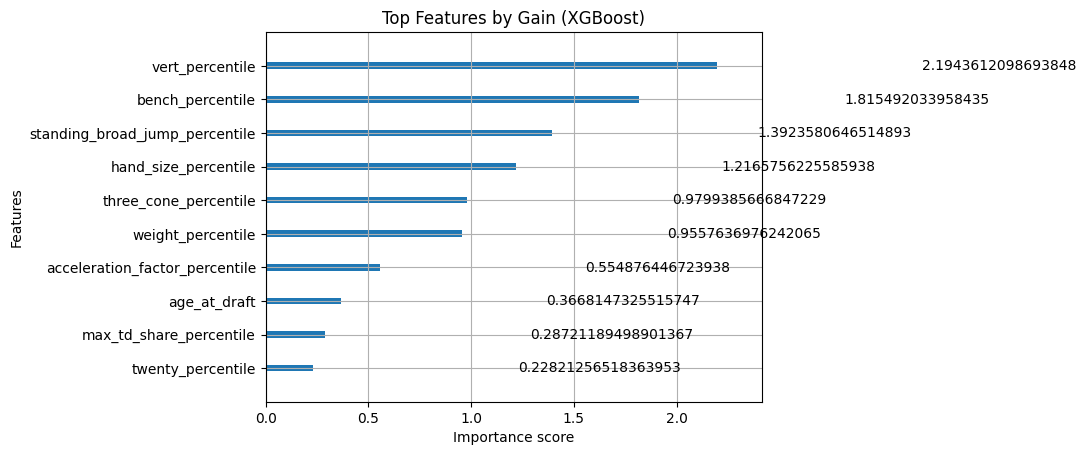

In [275]:
xgb.plot_importance(
    combined_model,
    importance_type='gain',
    max_num_features=10
)
plt.title("Top Features by Gain (XGBoost)")
plt.show()

Factors with high gain contribute more to the model's seperation of players who will play in the NFL versus those who won't.

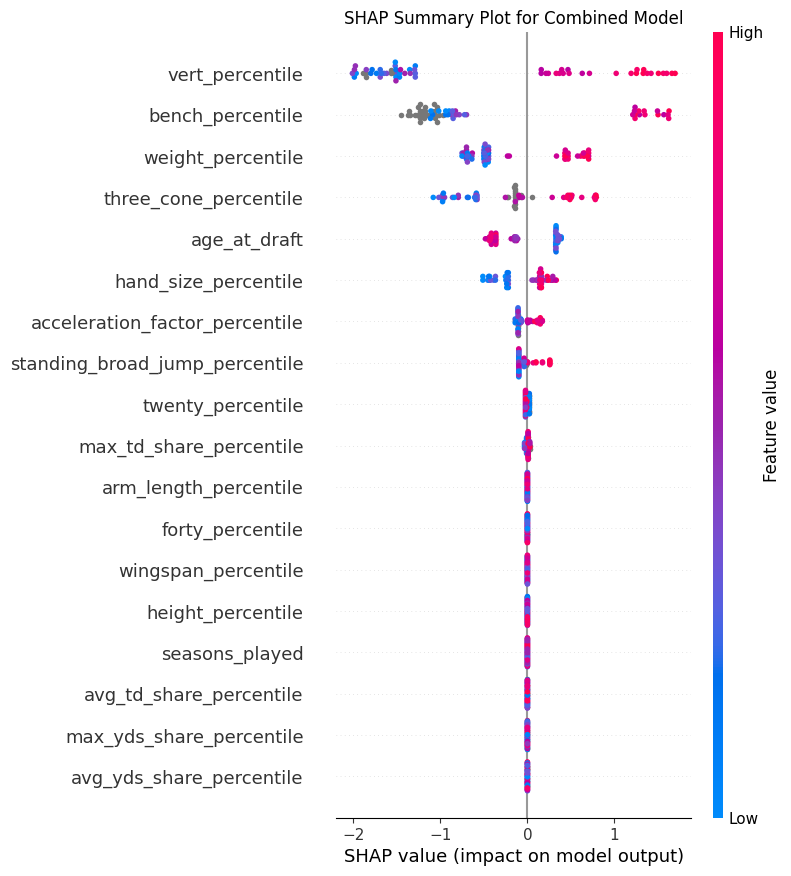

In [296]:
explainer = shap.TreeExplainer(combined_model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, show=False)

plt.title("SHAP Summary Plot for Combined Model")
plt.show()

SHAP values show how much each feature pushes the prediction higher or lower for individual players. Features at the top are most important overall. A stronger positive SHAP value means that feature is pushing the prediction towards "will play in NFL", while a negative SHAP value pushes it towards "won't play in NFL."

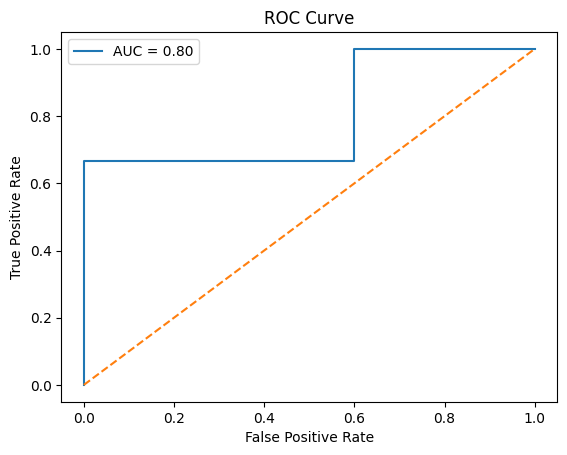

In [280]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

This curve shows the trade-off between catching more NFL players (true positives) versus incorrectly predicting non-NFL players as NFL players (false positives). The area under the curve quantifies the overall performance of the model in its ability to distinguish between NFL and non-NFL players.

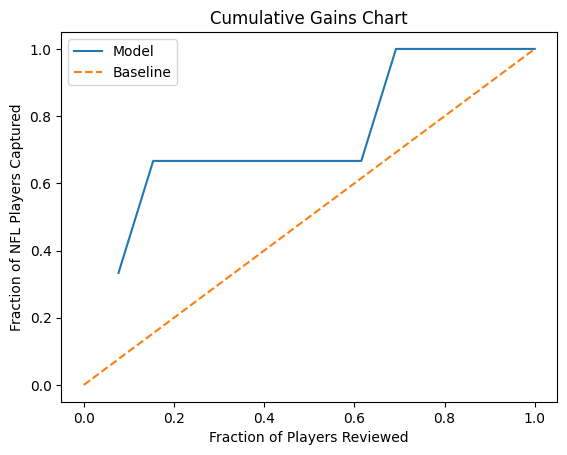

In [288]:
cumulative_lift = pd.DataFrame({
    "y_true": y_test,
    "y_prob": y_pred_proba
})

cumulative_lift = cumulative_lift.sort_values("y_prob", ascending=False).reset_index(drop=True)

cumulative_lift["cumulative_players"] = np.arange(1, len(cumulative_lift) + 1)
cumulative_lift["cumulative_pct_players"] = cumulative_lift["cumulative_players"] / len(cumulative_lift)

cumulative_lift["cumulative_nfl"] = cumulative_lift["y_true"].cumsum()
total_nfl = cumulative_lift["y_true"].sum()

cumulative_lift["cumulative_pct_nfl"] = cumulative_lift["cumulative_nfl"] / total_nfl

plt.plot(cumulative_lift["cumulative_pct_players"], cumulative_lift["cumulative_pct_nfl"], label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Baseline")

plt.xlabel("Fraction of Players Reviewed")
plt.ylabel("Fraction of NFL Players Captured")
plt.title("Cumulative Gains Chart")
plt.legend()
plt.show()

This chart visualizes how effectively the model identifies NFL players as you review more players in order of predicted probability (the higher ranked players are reviewed first). For example, anything to the left of 0.2 on the x-axis includes the top 20% of players according to the model. The dashed line represents random selection (baseline). The further the model's curve is above the baseline, the better it is at capturing NFL players early on.

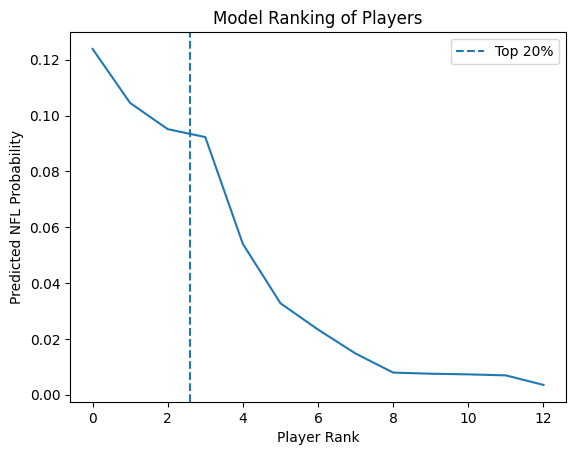

In [294]:
sorted_probs = np.sort(y_pred_proba)[::-1]

plt.plot(sorted_probs)
plt.axvline(0.20 * len(sorted_probs), linestyle='--', label='Top 20%')
plt.xlabel("Player Rank")
plt.ylabel("Predicted NFL Probability")
plt.title("Model Ranking of Players")
plt.legend()
plt.show()

This plot shows how the model ranks players based on likelihood of playing in the NFL. The x-axis represents the rankings of players from most to least likely to play in the NFL according to the model. The y-axis shows the predicted probability score for each player determined by the model. Any player to the left of the dashed line fall within the top 20% of predicted probabilities.

## TODO
#### Perform a model on those who DID play in the NFL to predict performance (e.g. snaps, yards, etc.) or how many snaps they played